# Дообучение BERT на данных по токсичности

Имеется набор текстов на русском языке из 140 тысяч строк. Тексты - посты и комментарии из российских соцсетей. Тексты были предварительно размечены вручную на наличие токсичности по нескольким категориям: не токсично, мат/нецензурное, грубое высказывание, дискриминация, оскорбление, угроза.

**Цель:** Использовать одну из предобученных моделей на основе Bert, дообучить её на имеющихся данных, добиться качества предсказаний по имеющимся данным roc_auc не менее 0.9.

В качестве предобученной модели будем использовать модель [*rubert-tiny-toxicity*](https://huggingface.co/cointegrated/rubert-tiny-toxicity), опубликованную на [*huggingface*](https://huggingface.co/). Для дообучения модели будем использовать объект класса *transformers.Trainer*. Обучать будем на GPU, 15 эпох, learning_rate - 1e-5.

**Описание данных:** Данные представляют собой набор текстов, каждому из которых соответствуют значения трех столбцов (mark1, mark2, mark3). В каждом столбце с оценками может быть проставлена одна из категорий токсичности (значение категории прописано в виде строки) или "0", если текст токсичности не содержит. Таким образом, каждому тексту может быть присвоено несколько категорий. Таким образом, задача сводится к классификации с несколькими метками (multi-label classification).

**Ход работы:**
1. Загрузка данных и библиотек.
2. Загрузка модели.
3. Предобработка данных:
   * формирование вектора меток;
   * исследование дисбаланса меток;
   * очистка текста.
4. Дообучение модели:
   * проработка дисбаланса меток;
   * токенизация;
   * дообучение.

## Загрузка данных и библиотек

In [1]:
#!pip install torch torchvision torchaudio --user --extra-index-url https://download.pytorch.org/whl/cu116
#!pip install --user --upgrade transformers==4.26.1

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings
import re
import os

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
from torch import nn
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy, Precision, Recall, AUC
import transformers 

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.mode.chained_assignment = None
rand_state=3208

In [3]:
print('torch version:', torch.__version__)
print('transformers version:', transformers.__version__)

torch version: 1.13.1+cu116
transformers version: 4.26.1


In [4]:
df = pd.read_csv('toxic_dataset.tsv', sep='\t')

In [5]:
display(df.head(10))
print()
display(df.describe(include='all'))
print()
df.info()
print()
print('\nДубликатов:', df.duplicated().sum())

,text_res,mark1,mark2,mark3
0,"Давайте всех на фронт, будем пидаров стрелять…...",Дискриминация,NaN,NaN
1,лиз давай спамить путин хуесос,Оскорбление,NaN,NaN
2,@Жижня я запрещаю тебе отвечать,0,NaN,NaN
3,"А у нас есть Виллы, фермеры?? То же, что и вез...",Оскорбление,NaN,NaN
4,"[id213949596|Валентина], пожертвовав ногой,ост...",0,NaN,NaN
5,"[id354619011|Ирина], ну ты дура! Чё ты несёшь?...",Оскорбление,NaN,NaN
6,"""Русская Лозовая. Последствия русского мира в ...",Оскорбление,NaN,NaN
7,@зубенко михаил последуйте своему совету) и не...,Оскорбление,NaN,NaN
8,Ну это по мнению этого паблика она признана. П...,Грубое высказывание,NaN,NaN
9,И туда накинули свои сети америкосы.,0,NaN,NaN


,text_res,mark1,mark2,mark3
count,139773,137417,12291,259
unique,118642,6,5,4
top,💥Интернет-магазин стильных платьев: shopblogge...,0,Мат/нецензурное,Дискриминация
freq,10,71019,7659,128



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text_res  139773 non-null  object
 1   mark1     137417 non-null  object
 2   mark2     12291 non-null   object
 3   mark3     259 non-null     object
dtypes: object(4)
memory usage: 4.3+ MB


Дубликатов: 17729


**Выводы:**
1. Пропусков в столбце с текстами нет. Но есть дубликаты, будем иметь это в виду, когда когда будет работать с дисбалансом меток.
2. Проставленные категории в основном сконцентрированы в первом столбце с оценками. Во втором и третьем оценок существенно меньше.
3. Есть некоторое количество строк, в которых значение токсичности проставлено в толбце mark2, а не в mark1.

## Загрузка модели

Модель *rubert-tiny-toxicity* уже рассчитана на классификацию с несколькими метками, количество меток - 5: non-toxic, insult, obscenity, threat, dangerous.

In [6]:
model_name = "cointegrated/rubert-tiny-toxicity"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)

In [7]:
model.config

BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny-toxicity",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "id2label": {
    "0": "non-toxic",
    "1": "insult",
    "2": "obscenity",
    "3": "threat",
    "4": "dangerous"
  },
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "label2id": {
    "dangerous": 4,
    "insult": 1,
    "non-toxic": 0,
    "obscenity": 2,
    "threat": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "multi_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 

In [8]:
if torch.cuda.is_available():
    cuda = torch.device('cuda')
    torch.cuda.empty_cache()
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:21,garbage_collection_threshold:0.6"
    model.cuda()
    cuda_id = torch.cuda.current_device()
    print('Cuda ON')
    print(f'CUDA version: {torch.version.cuda}')
    print(f'Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}')
else:
    print('No Cuda')

Cuda ON
CUDA version: 11.6
Name of current CUDA device: NVIDIA GeForce GT 1030


## Предобработка данных

Проверим, какие значения есть в столбцах с оценками. 

In [9]:
values = df['mark1'].append(df['mark2']).append(df['mark3'])
values = values.unique()
print('Уникальные значеня столбцов с оценками:', values)

Уникальные значеня столбцов с оценками: ['Дискриминация' 'Оскорбление' '0' 'Грубое высказывание' 'Мат/нецензурное'
 'Угроза' nan]


Посмотрим на строки, в которых оценка проставлена по втором столбце, а не в первом.

In [10]:
df[df['mark1'].isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 105 to 139768
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_res  2356 non-null   object
 1   mark1     0 non-null      object
 2   mark2     2356 non-null   object
 3   mark3     0 non-null      object
dtypes: object(4)
memory usage: 92.0+ KB


In [11]:
df.loc[df['mark1'].isna()].head(20)

,text_res,mark1,mark2,mark3
105,"не понятно, правда, модель чего Тупой пизды, о...",NaN,Мат/нецензурное,NaN
181,Вывел выродка и правильно таким замечания похе...,NaN,Грубое высказывание,NaN
229,"[id387636745|Николай], таких как вы уничтожают.",NaN,Грубое высказывание,NaN
261,"""Резня за власть в Кремле: кто станет следующи...",NaN,Грубое высказывание,NaN
372,просили показать чатик тупой внибляди дегенера...,NaN,Мат/нецензурное,NaN
393,"Обычно когда человечек прошаренный, он за 40-5...",NaN,Мат/нецензурное,NaN
395,"[id673806740|Елена], серьёзных игор нету, моя ...",NaN,Грубое высказывание,NaN
445,"[id89212301|Дмитрий], колорадик, посмотри проп...",NaN,Грубое высказывание,NaN
450,Бла бла бла не всех секрет что мусоры крышуют ...,NaN,Грубое высказывание,NaN
574,"Кровь на трусах укростерв означает, что их пог...",NaN,Мат/нецензурное,NaN


Переформатируем проставленные оценки так, чтобы на выходе для каждой строки был бы получен вектор, в каждой позиции которого была бы оценка соответствующей категории токсичности.

Предварительно создадим таблицу, в которой будут установлены соответствия имеющихся категорий на русском языке, категорий предобученной модели и id этих категорий.
* Соответствие категорий предобученной модели и их id возьмем из конфига модели;
* Нам не нужно знать, что означают категории предобученной модели. Соответствия номинальны. После дообучения категории должны работать на основе того, какие данные им будут соответствовать в датасете. Поэтому категорию "Грубое высказывание" отнесем к "dangerous", а категорию "Дискриминация" отнесем к "threat" вместе с "Угрозой" (поскольку Дискриминация и Угроза - самые малочисленные категории в имеющемся датасете, данных по ним очень мало). Таким образом, количество меток остаётся прежним.

In [12]:
target_vals = pd.Series(['Нет токсичности', 'Мат/нецензурное','Грубое высказывание', 'Дискриминация', 'Оскорбление', 'Угроза'])
target_cols = pd.Series(['non-toxic', 'obscenity', 'dangerous', 'threat', 'insult', 'threat'])
target_nums = pd.Series([0, 2, 4, 3, 1, 3])
target_table = pd.concat([target_nums, target_vals, target_cols], axis=1)
target_table.columns=['label_id', 'value_rus', 'value_eng']
target_table = target_table.sort_values(by='label_id').reset_index(drop=True)
target_table

,label_id,value_rus,value_eng
0,0,Нет токсичности,non-toxic
1,1,Оскорбление,insult
2,2,Мат/нецензурное,obscenity
3,3,Дискриминация,threat
4,3,Угроза,threat
5,4,Грубое высказывание,dangerous


In [13]:
def values_conf(vals):
    vals = list(vals)
    
    string = [0, 0, 0, 0, 0]
    
    for i in vals:
        if i in target_table['value_rus'].values:
            idx = int(target_table.loc[target_table['value_rus']==i, 'label_id'])
            string[idx] = 1
        elif i=='0':
            string[0] = 1
            
    return np.array(string, dtype='float32')

In [14]:
df = df.reset_index(drop=True)
tqdm.pandas()
df['labels'] = df[['mark1', 'mark2', 'mark3']].progress_apply(values_conf, axis=1)

100%|██████████| 139773/139773 [00:31<00:00, 4422.88it/s]


In [15]:
df.head(20)

,text_res,mark1,mark2,mark3,labels
0,"Давайте всех на фронт, будем пидаров стрелять…...",Дискриминация,NaN,NaN,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,лиз давай спамить путин хуесос,Оскорбление,NaN,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0]"
2,@Жижня я запрещаю тебе отвечать,0,NaN,NaN,"[1.0, 0.0, 0.0, 0.0, 0.0]"
3,"А у нас есть Виллы, фермеры?? То же, что и вез...",Оскорбление,NaN,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0]"
4,"[id213949596|Валентина], пожертвовав ногой,ост...",0,NaN,NaN,"[1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[id354619011|Ирина], ну ты дура! Чё ты несёшь?...",Оскорбление,NaN,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0]"
6,"""Русская Лозовая. Последствия русского мира в ...",Оскорбление,NaN,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0]"
7,@зубенко михаил последуйте своему совету) и не...,Оскорбление,NaN,NaN,"[0.0, 1.0, 0.0, 0.0, 0.0]"
8,Ну это по мнению этого паблика она признана. П...,Грубое высказывание,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 1.0]"
9,И туда накинули свои сети америкосы.,0,NaN,NaN,"[1.0, 0.0, 0.0, 0.0, 0.0]"


Теперь разделим вектор label на отдельные столбцы, чтобы проверить соотношение категорий.

In [16]:
lb = df['labels'].tolist()
lb = pd.DataFrame(lb, columns = ['non-toxic', 'insult', 'obscenity', 'threat', 'dangerous'])
df = pd.concat([df, lb], axis=1)
df = df.drop(['mark1', 'mark2', 'mark3'], axis=1)
df.head()

,text_res,labels,non-toxic,insult,obscenity,threat,dangerous
0,"Давайте всех на фронт, будем пидаров стрелять…...","[0.0, 0.0, 0.0, 1.0, 0.0]",0.00,0.00,0.00,1.00,0.00
1,лиз давай спамить путин хуесос,"[0.0, 1.0, 0.0, 0.0, 0.0]",0.00,1.00,0.00,0.00,0.00
2,@Жижня я запрещаю тебе отвечать,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00
3,"А у нас есть Виллы, фермеры?? То же, что и вез...","[0.0, 1.0, 0.0, 0.0, 0.0]",0.00,1.00,0.00,0.00,0.00
4,"[id213949596|Валентина], пожертвовав ногой,ост...","[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00


Посмотрим, нет ли в датасете строк, в которых проставлены одновременно и "отсутствие токсичности", и какая-либо категория токсичности.

In [17]:
df.loc[df['non-toxic']==1, ['insult' ,'obscenity', 'threat', 'dangerous']].value_counts()

insult  obscenity  threat  dangerous
0.00    0.00       0.00    0.00         71019
dtype: int64

Проверяем соотношение категорий (меток).

In [18]:
def labels_visual(data, columns):
    vals = [sum(data[i]) for i in columns]
    vals = pd.Series(vals, index = cols)

    vals.plot(kind='bar')
    plt.title('Распредлеление значений target', fontsize=20)
    plt.xlabel('Значения', fontsize=14)
    plt.ylabel('кол-вл строк', fontsize=14)
    vals = pd.concat([vals, vals/vals.sum()], axis=1)
    vals.columns=['Кол-во', '%']
    plt.show()

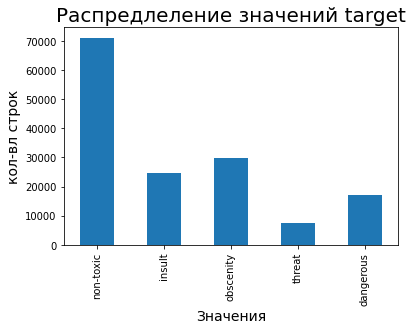

In [19]:
cols = ['non-toxic', 'insult', 'obscenity', 'threat', 'dangerous']
labels_visual(df, cols)

В датасете очень много строк с меткой 0. Выкидываем из датасета дубликаты по этой метке.

In [20]:
df1 = df[(df['non-toxic']==1)]
df2 = df[(df['non-toxic']!=1)]
df1 = df1.drop_duplicates(subset='text_res')
df3 = pd.concat([df1, df2])
df3 = shuffle(df3, random_state=rand_state)
df3 = df3.reset_index(drop=True)
print(df.shape)
print(df3.shape)

(139773, 7)
(130810, 7)


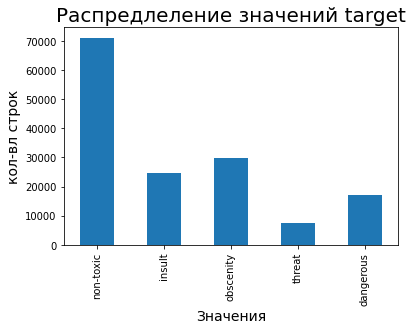

In [21]:
labels_visual(df, cols)

Создадим функцию для очистки текста.

In [22]:
def clear_text(text):
    clean = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
    clean = clean.lower().split()
    clean = ' '.join(clean)
    return clean

In [23]:
dataset = df3.reset_index(drop=True)
dataset['texts'] = dataset['text_res'].progress_apply(clear_text)

100%|██████████| 130810/130810 [00:02<00:00, 56152.80it/s]


Длина токенизированного текста для моделей Bert не должна превышать 512 токенов. На всякий случай проверим, много ли таких строк в датасете.

Строк, где более 512 слов: 100


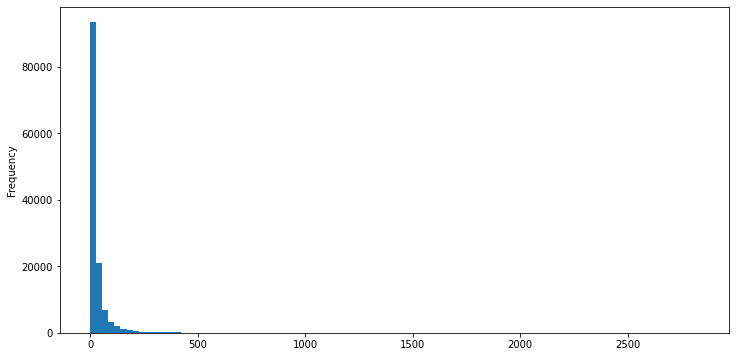

In [24]:
dataset['len'] = [len(i.split()) for i in dataset['texts']]
dataset['len'].plot(kind='hist', bins=100, figsize=(12, 6))

print('Строк, где более 512 слов:', len(dataset[dataset['len']>512]))

In [25]:
dataset.head(10)

,text_res,labels,non-toxic,insult,obscenity,threat,dangerous,texts,len
0,ну не знаю<br>немцы сами ведь решают идти на т...,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,ну не знаю немцы сами ведь решают идти на тако...,20
1,"неядовитых паучков Покажи мне, блять, хоть одн...","[0.0, 1.0, 1.0, 0.0, 0.0]",0.00,1.00,1.00,0.00,0.00,неядовитых паучков покажи мне блять хоть одног...,103
2,"Несмотря на то, что я очень четко чувствую раз...","[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,несмотря на то что я очень четко чувствую разн...,84
3,"Адвокатам, участвующим в уголовным делах по на...","[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,адвокатам участвующим в уголовным делах по наз...,84
4,Наконец-то удалось ближе рассмотреть водосброс...,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,наконец то удалось ближе рассмотреть водосброс...,127
5,"Michael Simonyan, я пойду по статье ""оскорблен...","[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,я пойду по статье оскорбление чувст долбаёбов,7
6,"[id547060639|Антон], СУКА, ЧТО ЗА ДАУНИЗМ, ЗАЕ...","[0.0, 0.0, 1.0, 0.0, 0.0]",0.00,0.00,1.00,0.00,0.00,антон сука что за даунизм заебали своим сыром ...,28
7,бомж<br>|🎁|🖕|🍓| Удача не на твоей стороне. Выи...,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,бомж удача не на твоей стороне выигрыш,7
8,Прогулочная коляска фирмы Rant/очень лёгкая/уд...,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.00,0.00,0.00,0.00,0.00,прогулочная коляска фирмы очень лёгкая удобно ...,27
9,Что за долб@ебы !?!?<br>Как ???,"[0.0, 0.0, 1.0, 0.0, 0.0]",0.00,0.00,1.00,0.00,0.00,что за долб ебы как,5


## Дообучение модели

Заранее выделим часть датасета для тестирования (10%) и сохраним в отдельном файле. В тестовом датасете сохранен дисбаланс меток.

In [26]:
train_val, test_dataset = train_test_split(dataset, test_size=0.1, random_state=rand_state)

print(train_val.shape)
print(test_dataset.shape)

(117729, 9)
(13081, 9)


In [27]:
test_dataset.to_csv(path_or_buf='test_dataset.tsv', sep='\t', index=False, columns=test_dataset.columns, encoding='utf-8')

Проверим соотношение меток в тренировочном и тестовом датасетах.

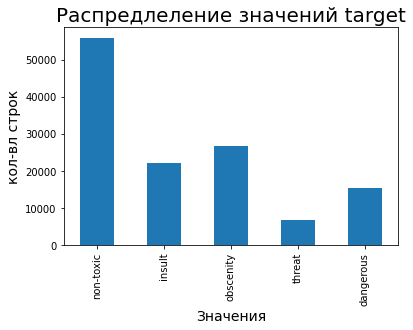

In [28]:
labels_visual(train_val, cols)

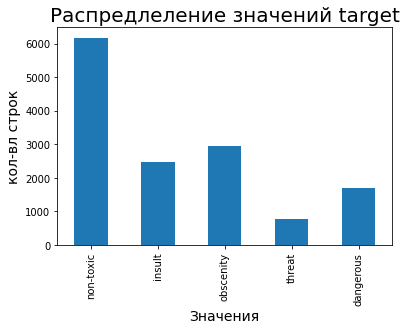

In [29]:
labels_visual(test_dataset, cols)

Теперь проработаем дисбаланс меток в тренировочном датасете. Для этого сократим объем данных по метке "0" ("non-toxic") с помощью downsample и удвоим объем данных по метке "3" ("threat") с помощью upsample.

In [30]:
def downsample(data, col, fraction):
    data_zeros = data.loc[data[col]==0]
    data_ones = data.loc[data[col]==1]

    data_ones_frac = data_ones.sample(frac=fraction, random_state=rand_state)
    data_downsampled = pd.concat([data_ones_frac] + [data_zeros])
    data_downsampled = shuffle(data_downsampled, random_state=rand_state)
    
    return data_downsampled

In [31]:
def upsample(data, col, repeat):
    data_zeros = data.loc[data[col]==0]
    data_ones = data.loc[data[col]==1]

    data_upsampled = pd.concat([data_zeros] + [data_ones] * repeat)
    data_upsampled = shuffle(data_upsampled, random_state=rand_state)
    
    return data_upsampled

In [32]:
train_val_downsampled = downsample(train_val, 'non-toxic', 0.6)

In [33]:
train_val_upsampled = upsample(train_val_downsampled, 'threat', 2)

Посмотрим теперь на соотношение меток.

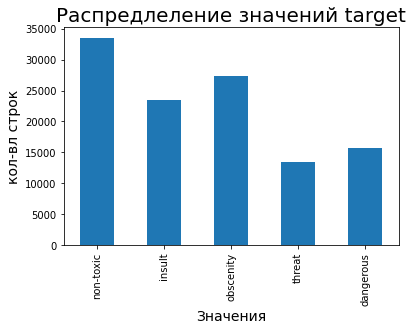

In [34]:
train_val_upsampled = train_val_upsampled.reset_index(drop=True)
labels_visual(train_val_upsampled, cols)

Сохраним веса меток в отдельной переменной.

In [35]:
vals = [sum(train_val_upsampled[i]) for i in train_val_upsampled[cols]]
vals = np.array(vals)/sum(vals)
vals

array([0.29548819, 0.20747268, 0.24058865, 0.11869933, 0.13775115])

Разделим датасет на тренировочный и валидационный.

In [36]:
features_list = list(train_val_upsampled['texts'])
target_list = list(train_val_upsampled['labels'])

In [37]:
features_train, features_valid, target_train, target_valid = train_test_split(features_list,
                                              target_list, test_size=0.2, random_state=rand_state)

print(len(features_train))
print(len(target_train))
print(len(features_valid))
print(len(target_valid))

81687
81687
20422
20422


Проведем токенизацию тренировочной и валидационной выборок.

In [38]:
features_train_tokenized = tokenizer(features_train, return_tensors='pt', padding=True, truncation=True, max_length=512)
features_valid_tokenized = tokenizer(features_valid, return_tensors='pt', padding=True, truncation=True, max_length=512)

Создадим датасеты для обучения. Для дообучения модели будем использовать объект класса *transformers.Trainer*. Поэтому данные переведем в соответствующий вид (*torch.utils.data.Dataset*).

In [39]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

Токенизируем данные.

In [40]:
train_dataset = Dataset(features_train_tokenized, target_train)
valid_dataset = Dataset(features_valid_tokenized, target_valid)

Определим функцию для получения метрик. Используем метрики для классификации с несколькими метками. Для AUC используем полученные ранее веса меток. Для Precision и Recall утасновим thresholds = 0.3.

In [41]:
ca = CategoricalAccuracy(name='categorical_accuracy', dtype='float32')
cc = CategoricalCrossentropy(name='categorical_crossentropy', dtype='float32', from_logits=True, label_smoothing=0)
prec = Precision(name='precision', dtype='float32', thresholds=0.3)
rec = Recall(name='recall', dtype='float32', thresholds=0.3)
pr = AUC(curve='PR', name='PR', dtype='float32', multi_label=True, num_labels=5, label_weights=vals, from_logits=False)
auc = AUC(curve='ROC', name='roc_auc', dtype='float32', multi_label=True, num_labels=5, label_weights=vals, from_logits=False)

def compute_metrics(p):
    logits, labels = p
    logits = torch.as_tensor(logits, dtype=torch.float32, device=torch.device('cpu'))
    proba = torch.sigmoid(logits).cpu().numpy()

    ca.reset_state()
    cc.reset_state()
    prec.reset_state()
    rec.reset_state()
    pr.reset_state()
    auc.reset_state()
    
    ca_score = ca(labels, proba).numpy()
    cc_score = cc(labels, logits).numpy()
    prec_score = prec(labels, proba).numpy()
    rec_score = rec(labels, proba).numpy()
    pr_score = pr(labels, proba).numpy()
    auc_score = auc(labels, proba).numpy()

    return {'categorical_accuracy': ca_score,
            'categorical_crossentropy': cc_score,
            'precision': prec_score,
            'recall': rec_score,
            'PR': pr_score,
            'roc_auc': auc_score}

In [42]:
args = TrainingArguments(
    output_dir = 'output_epoch',
    evaluation_strategy = 'epoch',
    logging_strategy = 'epoch',
    gradient_checkpointing = True,
    per_device_train_batch_size = 3,
    per_device_eval_batch_size = 3,
    learning_rate = 0.00001,
    num_train_epochs = 15,
    seed = rand_state)

trainer = Trainer(
    model = model,
    args = args,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    compute_metrics = compute_metrics)

In [43]:
trainer.train()

***** Running training *****
  Num examples = 81687
  Num Epochs = 15
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 408435
  Number of trainable parameters = 11785733


Epoch,Training Loss,Validation Loss,Categorical Accuracy,Categorical Crossentropy,Precision,Recall,Pr,Roc Auc
1,0.320300,0.295146,0.669670,1.320541,0.687582,0.767464,0.779384,0.917970
2,0.278200,0.281436,0.695329,1.271277,0.704097,0.781639,0.797500,0.926082
3,0.261900,0.282028,0.706297,1.321726,0.718253,0.782257,0.806380,0.929422
4,0.249500,0.295805,0.708990,1.439245,0.719887,0.779873,0.806038,0.929737
5,0.240400,0.298518,0.720595,1.460518,0.724307,0.791089,0.812588,0.932215
6,0.230600,0.303846,0.721085,1.527524,0.738670,0.788837,0.810364,0.931491
7,0.223800,0.315328,0.726031,1.596681,0.736391,0.796255,0.811373,0.932119
8,0.215400,0.323186,0.731319,1.677870,0.747540,0.788439,0.809795,0.930919
9,0.208700,0.327938,0.728822,1.707322,0.753499,0.789367,0.810101,0.930838
10,0.204300,0.332319,0.729703,1.727375,0.750000,0.788616,0.808798,0.930404


Saving model checkpoint to output_epoch\checkpoint-500
Configuration saved in output_epoch\checkpoint-500\config.json
Model weights saved in output_epoch\checkpoint-500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-1000
Configuration saved in output_epoch\checkpoint-1000\config.json
Model weights saved in output_epoch\checkpoint-1000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-1500
Configuration saved in output_epoch\checkpoint-1500\config.json
Model weights saved in output_epoch\checkpoint-1500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-2000
Configuration saved in output_epoch\checkpoint-2000\config.json
Model weights saved in output_epoch\checkpoint-2000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-2500
Configuration saved in output_epoch\checkpoint-2500\config.json
Model weights saved in output_epoch\checkpoint-2500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-30

Saving model checkpoint to output_epoch\checkpoint-22000
Configuration saved in output_epoch\checkpoint-22000\config.json
Model weights saved in output_epoch\checkpoint-22000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-22500
Configuration saved in output_epoch\checkpoint-22500\config.json
Model weights saved in output_epoch\checkpoint-22500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-23000
Configuration saved in output_epoch\checkpoint-23000\config.json
Model weights saved in output_epoch\checkpoint-23000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-23500
Configuration saved in output_epoch\checkpoint-23500\config.json
Model weights saved in output_epoch\checkpoint-23500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-24000
Configuration saved in output_epoch\checkpoint-24000\config.json
Model weights saved in output_epoch\checkpoint-24000\pytorch_model.bin
Saving model checkpoint to output_e

Configuration saved in output_epoch\checkpoint-43000\config.json
Model weights saved in output_epoch\checkpoint-43000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-43500
Configuration saved in output_epoch\checkpoint-43500\config.json
Model weights saved in output_epoch\checkpoint-43500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-44000
Configuration saved in output_epoch\checkpoint-44000\config.json
Model weights saved in output_epoch\checkpoint-44000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-44500
Configuration saved in output_epoch\checkpoint-44500\config.json
Model weights saved in output_epoch\checkpoint-44500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-45000
Configuration saved in output_epoch\checkpoint-45000\config.json
Model weights saved in output_epoch\checkpoint-45000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-45500
Configuration saved in output_epoch

Saving model checkpoint to output_epoch\checkpoint-54500
Configuration saved in output_epoch\checkpoint-54500\config.json
Model weights saved in output_epoch\checkpoint-54500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-55000
Configuration saved in output_epoch\checkpoint-55000\config.json
Model weights saved in output_epoch\checkpoint-55000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-55500
Configuration saved in output_epoch\checkpoint-55500\config.json
Model weights saved in output_epoch\checkpoint-55500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-56000
Configuration saved in output_epoch\checkpoint-56000\config.json
Model weights saved in output_epoch\checkpoint-56000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-56500
Configuration saved in output_epoch\checkpoint-56500\config.json
Model weights saved in output_epoch\checkpoint-56500\pytorch_model.bin
Saving model checkpoint to output_e

Model weights saved in output_epoch\checkpoint-75500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-76000
Configuration saved in output_epoch\checkpoint-76000\config.json
Model weights saved in output_epoch\checkpoint-76000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-76500
Configuration saved in output_epoch\checkpoint-76500\config.json
Model weights saved in output_epoch\checkpoint-76500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-77000
Configuration saved in output_epoch\checkpoint-77000\config.json
Model weights saved in output_epoch\checkpoint-77000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-77500
Configuration saved in output_epoch\checkpoint-77500\config.json
Model weights saved in output_epoch\checkpoint-77500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-78000
Configuration saved in output_epoch\checkpoint-78000\config.json
Model weights saved in output_epoch

Saving model checkpoint to output_epoch\checkpoint-97000
Configuration saved in output_epoch\checkpoint-97000\config.json
Model weights saved in output_epoch\checkpoint-97000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-97500
Configuration saved in output_epoch\checkpoint-97500\config.json
Model weights saved in output_epoch\checkpoint-97500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-98000
Configuration saved in output_epoch\checkpoint-98000\config.json
Model weights saved in output_epoch\checkpoint-98000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-98500
Configuration saved in output_epoch\checkpoint-98500\config.json
Model weights saved in output_epoch\checkpoint-98500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-99000
Configuration saved in output_epoch\checkpoint-99000\config.json
Model weights saved in output_epoch\checkpoint-99000\pytorch_model.bin
Saving model checkpoint to output_e

Model weights saved in output_epoch\checkpoint-117500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-118000
Configuration saved in output_epoch\checkpoint-118000\config.json
Model weights saved in output_epoch\checkpoint-118000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-118500
Configuration saved in output_epoch\checkpoint-118500\config.json
Model weights saved in output_epoch\checkpoint-118500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-119000
Configuration saved in output_epoch\checkpoint-119000\config.json
Model weights saved in output_epoch\checkpoint-119000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-119500
Configuration saved in output_epoch\checkpoint-119500\config.json
Model weights saved in output_epoch\checkpoint-119500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-120000
Configuration saved in output_epoch\checkpoint-120000\config.json
Model weights saved 

Configuration saved in output_epoch\checkpoint-138500\config.json
Model weights saved in output_epoch\checkpoint-138500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-139000
Configuration saved in output_epoch\checkpoint-139000\config.json
Model weights saved in output_epoch\checkpoint-139000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-139500
Configuration saved in output_epoch\checkpoint-139500\config.json
Model weights saved in output_epoch\checkpoint-139500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-140000
Configuration saved in output_epoch\checkpoint-140000\config.json
Model weights saved in output_epoch\checkpoint-140000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-140500
Configuration saved in output_epoch\checkpoint-140500\config.json
Model weights saved in output_epoch\checkpoint-140500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-141000
Configuration saved 

Configuration saved in output_epoch\checkpoint-159500\config.json
Model weights saved in output_epoch\checkpoint-159500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-160000
Configuration saved in output_epoch\checkpoint-160000\config.json
Model weights saved in output_epoch\checkpoint-160000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-160500
Configuration saved in output_epoch\checkpoint-160500\config.json
Model weights saved in output_epoch\checkpoint-160500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-161000
Configuration saved in output_epoch\checkpoint-161000\config.json
Model weights saved in output_epoch\checkpoint-161000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-161500
Configuration saved in output_epoch\checkpoint-161500\config.json
Model weights saved in output_epoch\checkpoint-161500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-162000
Configuration saved 

Saving model checkpoint to output_epoch\checkpoint-180500
Configuration saved in output_epoch\checkpoint-180500\config.json
Model weights saved in output_epoch\checkpoint-180500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-181000
Configuration saved in output_epoch\checkpoint-181000\config.json
Model weights saved in output_epoch\checkpoint-181000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-181500
Configuration saved in output_epoch\checkpoint-181500\config.json
Model weights saved in output_epoch\checkpoint-181500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-182000
Configuration saved in output_epoch\checkpoint-182000\config.json
Model weights saved in output_epoch\checkpoint-182000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-182500
Configuration saved in output_epoch\checkpoint-182500\config.json
Model weights saved in output_epoch\checkpoint-182500\pytorch_model.bin
Saving model checkpo

Model weights saved in output_epoch\checkpoint-201000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-201500
Configuration saved in output_epoch\checkpoint-201500\config.json
Model weights saved in output_epoch\checkpoint-201500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-202000
Configuration saved in output_epoch\checkpoint-202000\config.json
Model weights saved in output_epoch\checkpoint-202000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-202500
Configuration saved in output_epoch\checkpoint-202500\config.json
Model weights saved in output_epoch\checkpoint-202500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-203000
Configuration saved in output_epoch\checkpoint-203000\config.json
Model weights saved in output_epoch\checkpoint-203000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-203500
Configuration saved in output_epoch\checkpoint-203500\config.json
Model weights saved 

Configuration saved in output_epoch\checkpoint-222000\config.json
Model weights saved in output_epoch\checkpoint-222000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-222500
Configuration saved in output_epoch\checkpoint-222500\config.json
Model weights saved in output_epoch\checkpoint-222500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-223000
Configuration saved in output_epoch\checkpoint-223000\config.json
Model weights saved in output_epoch\checkpoint-223000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-223500
Configuration saved in output_epoch\checkpoint-223500\config.json
Model weights saved in output_epoch\checkpoint-223500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-224000
Configuration saved in output_epoch\checkpoint-224000\config.json
Model weights saved in output_epoch\checkpoint-224000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-224500
Configuration saved 

Configuration saved in output_epoch\checkpoint-243000\config.json
Model weights saved in output_epoch\checkpoint-243000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-243500
Configuration saved in output_epoch\checkpoint-243500\config.json
Model weights saved in output_epoch\checkpoint-243500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-244000
Configuration saved in output_epoch\checkpoint-244000\config.json
Model weights saved in output_epoch\checkpoint-244000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-244500
Configuration saved in output_epoch\checkpoint-244500\config.json
Model weights saved in output_epoch\checkpoint-244500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-245000
Configuration saved in output_epoch\checkpoint-245000\config.json
Model weights saved in output_epoch\checkpoint-245000\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 20422
  Batch size = 3
Saving 

Saving model checkpoint to output_epoch\checkpoint-264000
Configuration saved in output_epoch\checkpoint-264000\config.json
Model weights saved in output_epoch\checkpoint-264000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-264500
Configuration saved in output_epoch\checkpoint-264500\config.json
Model weights saved in output_epoch\checkpoint-264500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-265000
Configuration saved in output_epoch\checkpoint-265000\config.json
Model weights saved in output_epoch\checkpoint-265000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-265500
Configuration saved in output_epoch\checkpoint-265500\config.json
Model weights saved in output_epoch\checkpoint-265500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-266000
Configuration saved in output_epoch\checkpoint-266000\config.json
Model weights saved in output_epoch\checkpoint-266000\pytorch_model.bin
Saving model checkpo

Model weights saved in output_epoch\checkpoint-284500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-285000
Configuration saved in output_epoch\checkpoint-285000\config.json
Model weights saved in output_epoch\checkpoint-285000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-285500
Configuration saved in output_epoch\checkpoint-285500\config.json
Model weights saved in output_epoch\checkpoint-285500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-286000
Configuration saved in output_epoch\checkpoint-286000\config.json
Model weights saved in output_epoch\checkpoint-286000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-286500
Configuration saved in output_epoch\checkpoint-286500\config.json
Model weights saved in output_epoch\checkpoint-286500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-287000
Configuration saved in output_epoch\checkpoint-287000\config.json
Model weights saved 

Configuration saved in output_epoch\checkpoint-305500\config.json
Model weights saved in output_epoch\checkpoint-305500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-306000
Configuration saved in output_epoch\checkpoint-306000\config.json
Model weights saved in output_epoch\checkpoint-306000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-306500
Configuration saved in output_epoch\checkpoint-306500\config.json
Model weights saved in output_epoch\checkpoint-306500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-307000
Configuration saved in output_epoch\checkpoint-307000\config.json
Model weights saved in output_epoch\checkpoint-307000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-307500
Configuration saved in output_epoch\checkpoint-307500\config.json
Model weights saved in output_epoch\checkpoint-307500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-308000
Configuration saved 

Configuration saved in output_epoch\checkpoint-326500\config.json
Model weights saved in output_epoch\checkpoint-326500\pytorch_model.bin
***** Running Evaluation *****
  Num examples = 20422
  Batch size = 3
Saving model checkpoint to output_epoch\checkpoint-327000
Configuration saved in output_epoch\checkpoint-327000\config.json
Model weights saved in output_epoch\checkpoint-327000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-327500
Configuration saved in output_epoch\checkpoint-327500\config.json
Model weights saved in output_epoch\checkpoint-327500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-328000
Configuration saved in output_epoch\checkpoint-328000\config.json
Model weights saved in output_epoch\checkpoint-328000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-328500
Configuration saved in output_epoch\checkpoint-328500\config.json
Model weights saved in output_epoch\checkpoint-328500\pytorch_model.bin
Saving 

Saving model checkpoint to output_epoch\checkpoint-347500
Configuration saved in output_epoch\checkpoint-347500\config.json
Model weights saved in output_epoch\checkpoint-347500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-348000
Configuration saved in output_epoch\checkpoint-348000\config.json
Model weights saved in output_epoch\checkpoint-348000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-348500
Configuration saved in output_epoch\checkpoint-348500\config.json
Model weights saved in output_epoch\checkpoint-348500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-349000
Configuration saved in output_epoch\checkpoint-349000\config.json
Model weights saved in output_epoch\checkpoint-349000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-349500
Configuration saved in output_epoch\checkpoint-349500\config.json
Model weights saved in output_epoch\checkpoint-349500\pytorch_model.bin
Saving model checkpo

Model weights saved in output_epoch\checkpoint-368000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-368500
Configuration saved in output_epoch\checkpoint-368500\config.json
Model weights saved in output_epoch\checkpoint-368500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-369000
Configuration saved in output_epoch\checkpoint-369000\config.json
Model weights saved in output_epoch\checkpoint-369000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-369500
Configuration saved in output_epoch\checkpoint-369500\config.json
Model weights saved in output_epoch\checkpoint-369500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-370000
Configuration saved in output_epoch\checkpoint-370000\config.json
Model weights saved in output_epoch\checkpoint-370000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-370500
Configuration saved in output_epoch\checkpoint-370500\config.json
Model weights saved 

Configuration saved in output_epoch\checkpoint-389000\config.json
Model weights saved in output_epoch\checkpoint-389000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-389500
Configuration saved in output_epoch\checkpoint-389500\config.json
Model weights saved in output_epoch\checkpoint-389500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-390000
Configuration saved in output_epoch\checkpoint-390000\config.json
Model weights saved in output_epoch\checkpoint-390000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-390500
Configuration saved in output_epoch\checkpoint-390500\config.json
Model weights saved in output_epoch\checkpoint-390500\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-391000
Configuration saved in output_epoch\checkpoint-391000\config.json
Model weights saved in output_epoch\checkpoint-391000\pytorch_model.bin
Saving model checkpoint to output_epoch\checkpoint-391500
Configuration saved 

TrainOutput(global_step=408435, training_loss=0.22605693789632988, metrics={'train_runtime': 90977.9, 'train_samples_per_second': 13.468, 'train_steps_per_second': 4.489, 'total_flos': 9039187203333120.0, 'train_loss': 0.22605693789632988, 'epoch': 15.0})

In [46]:
model.save_pretrained('model_toxicity_final')
tokenizer.save_pretrained('model_toxicity_final')

Configuration saved in model_toxicity_final\config.json
Model weights saved in model_toxicity_final\pytorch_model.bin
tokenizer config file saved in model_toxicity_final\tokenizer_config.json
Special tokens file saved in model_toxicity_final\special_tokens_map.json


('model_toxicity_final\\tokenizer_config.json',
 'model_toxicity_final\\special_tokens_map.json',
 'model_toxicity_final\\vocab.txt',
 'model_toxicity_final\\added_tokens.json')